<a href="https://colab.research.google.com/github/Nithyasreecp/Real-time-crop-disease-detection-based-on-the-leaf-image/blob/main/CROP_DETECTION_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [ ]:
print("✅ TensorFlow version:", tf.__version__)

✅ TensorFlow version: 2.19.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/MyDrive/plant village dataset"

In [ ]:
# Use ImageDataGenerator for preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    subset='training',
    class_mode='categorical'
)

val_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    subset='validation',
    class_mode='categorical'
)

Found 5878 images belonging to 6 classes.
Found 1467 images belonging to 6 classes.


In [ ]:
#STEP 3: Build Model (MobileNetV2)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
preds = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
#STEP 4: Train Model

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen)
)


Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2222s 12s/step - accuracy: 0.3462 - loss: 1.7508 - val_accuracy: 0.7478 - val_loss: 0.9080
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - accuracy: 0.6846 - loss: 0.9252 - val_accuracy: 0.8773 - val_loss: 0.5428
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.8152 - loss: 0.6061 - val_accuracy: 0.9148 - val_loss: 0.3998
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.8659 - loss: 0.4633 - val_accuracy: 0.9352 - val_loss: 0.3189
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 373s 2s/step - accuracy: 0.9053 - loss: 0.3653 - val_accuracy: 0.9359 - val_loss: 0.2638
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.9111 - loss: 0.3224 - val_accuracy: 0.9543 - val_loss: 0.2326
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - accuracy: 0.9197 - loss: 0.2886 - val_accuracy: 0.9557 - val_loss: 0.2031
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - accuracy: 0.9290 - loss: 0.2528 - val_ac

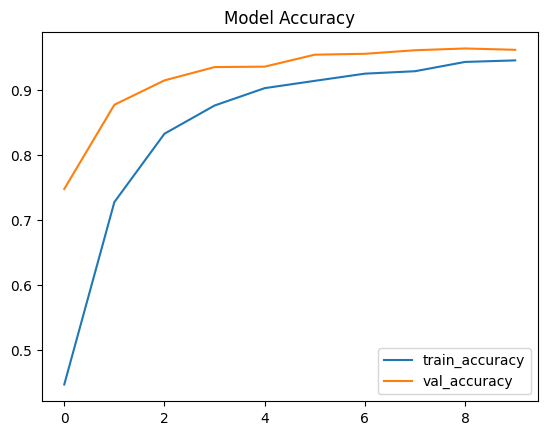

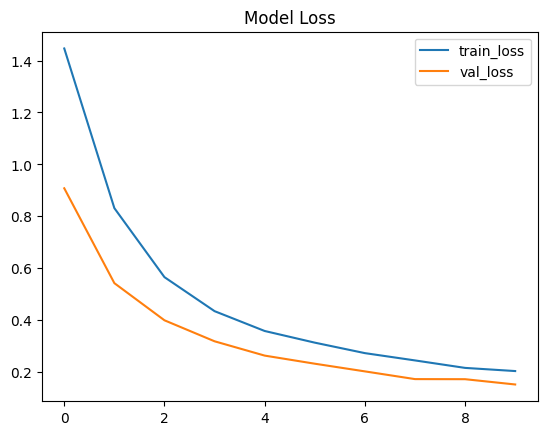

In [ ]:
 #STEP 5: Plot Training Performance

 plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title("Model Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Model Loss")
plt.legend()
plt.show()

In [ ]:
#STEP 6: Grad-CAM Visualization

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Predicted Class: Pepper__bell___Bacterial_spot
Confidence: 0.99698025


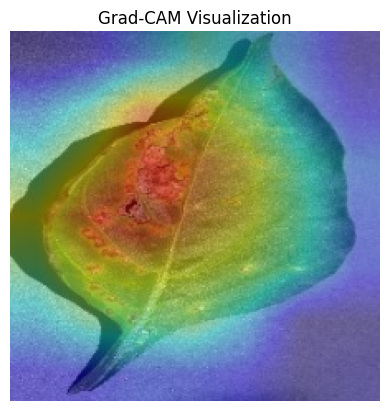

In [ ]:
img_path = "/content/drive/MyDrive/dataset plant village/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG"  # change to your test image path
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array / 255.0, axis=0)

preds = model.predict(img_array)
pred_class = np.argmax(preds)
print("Predicted Class:", list(train_gen.class_indices.keys())[pred_class])
print("Confidence:", preds[0][pred_class])


# Generate Grad-CAM
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name='Conv_1')


# Overlay heatmap on image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM Visualization")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Predicted Class: Potato___Early_blight
Confidence: 0.9150318


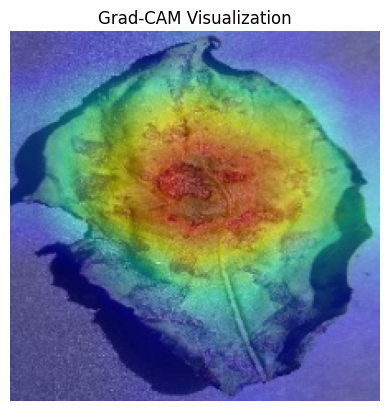

In [ ]:
img_path = "/content/drive/MyDrive/dataset plant village/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG"  # change to your test image path
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array / 255.0, axis=0)

preds = model.predict(img_array)
pred_class = np.argmax(preds)
print("Predicted Class:", list(train_gen.class_indices.keys())[pred_class])
print("Confidence:", preds[0][pred_class])


# Generate Grad-CAM
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name='Conv_1')



# Overlay heatmap on image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM Visualization")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Predicted Class: Tomato_Bacterial_spot
Confidence: 0.65746695


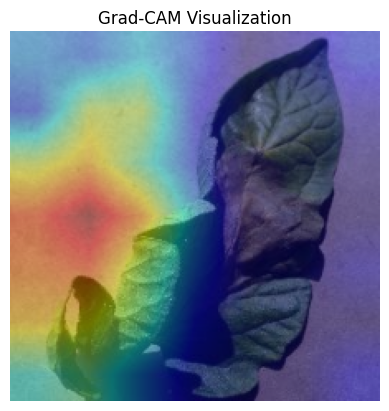

In [ ]:
img_path = "/content/drive/MyDrive/dataset plant village/Tomato_Late_blight/0003faa8-4b27-4c65-bf42-6d9e352ca1a5___RS_Late.B 4946.JPG"  # change to your test image path
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array / 255.0, axis=0)

preds = model.predict(img_array)
pred_class = np.argmax(preds)
print("Predicted Class:", list(train_gen.class_indices.keys())[pred_class])
print("Confidence:", preds[0][pred_class])


# Generate Grad-CAM
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name='Conv_1')



# Overlay heatmap on image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM Visualization")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Predicted Class: Tomato_Bacterial_spot
Confidence: 0.79253477


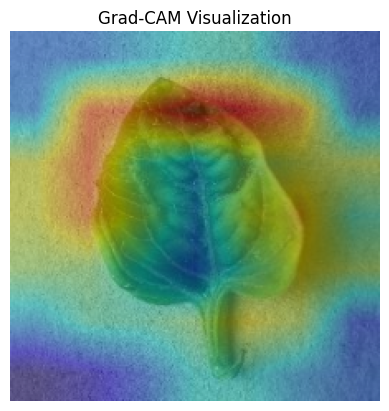

In [ ]:
img_path = "/content/drive/MyDrive/dataset plant village/Tomato__Tomato_YellowLeaf__Curl_Virus/00139ae8-d881-4edb-925f-46584b0bd68c___YLCV_NREC 2944.JPG"  # change to your test image path
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array / 255.0, axis=0)

preds = model.predict(img_array)
pred_class = np.argmax(preds)
print("Predicted Class:", list(train_gen.class_indices.keys())[pred_class])
print("Confidence:", preds[0][pred_class])


# Generate Grad-CAM
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name='Conv_1')



# Overlay heatmap on image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM Visualization")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted Class: Potato___healthy
Confidence: 0.8956968


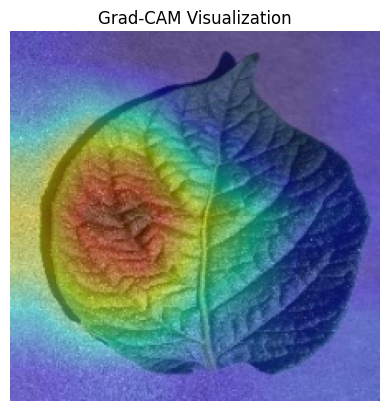

In [ ]:
img_path = "/content/drive/MyDrive/dataset plant village/Potato___healthy/00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864.JPG"  # change to your test image path
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array / 255.0, axis=0)

preds = model.predict(img_array)
pred_class = np.argmax(preds)
print("Predicted Class:", list(train_gen.class_indices.keys())[pred_class])
print("Confidence:", preds[0][pred_class])


# Generate Grad-CAM
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name='Conv_1')



# Overlay heatmap on image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM Visualization")
plt.axis('off')
plt.show()

In [ ]:
#STEP 8: Farmer Suggestions

# Dictionary mapping diseases to helpful advice for farmers
disease_solutions = {
    "Early_blight": {
        "description": "Fungal disease caused by Alternaria solani affecting tomato and potato.",
        "suggestion": "Remove infected leaves, avoid overhead watering, and apply a copper-based fungicide. Rotate crops regularly."
    },
    "Late_blight": {
        "description": "Caused by Phytophthora infestans, rapidly spreads under cool and moist conditions.",
        "suggestion": "Destroy infected plants immediately, use resistant varieties, and spray with fungicides like mancozeb or chlorothalonil."
    },
    "Bacterial_spot": {
        "description": "Bacterial disease common in tomatoes and peppers caused by Xanthomonas.",
        "suggestion": "Use disease-free seeds, avoid touching plants when wet, and apply copper-based bactericides."
    },
    "Powdery_mildew": {
        "description": "White powdery fungal growth affecting leaves of many crops.",
        "suggestion": "Improve air circulation, avoid excess nitrogen fertilizer, and use sulfur-based fungicides."
    },
    "Canker": {
        "description": "Can be caused by viruses, fungi, or bacteria, leading to cracking on stems or fruits.",
        "suggestion": "Prune infected branches, disinfect tools, and apply appropriate fungicide or bactericide."
    },
    "Healthy": {
        "description": "No disease detected.",
        "suggestion": "Maintain regular monitoring and provide balanced fertilizer and watering."
    }
}


In [ ]:

# Get predicted class name
predicted_label = list(train_gen.class_indices.keys())[pred_class]

# Display prediction results with suggestions
print("\n Predicted Disease:", predicted_label)
print(" Confidence Score: {:.2f}%".format(preds[0][pred_class] * 100))

if predicted_label in disease_solutions:
    print("\n Description:", disease_solutions[predicted_label]["description"])
    print(" Suggestion for Farmers:", disease_solutions[predicted_label]["suggestion"])
else:
    print("\n No suggestion available for this disease.")


 Predicted Disease: Pepper__bell___Bacterial_spot
 Confidence Score: 99.64%

 No suggestion available for this disease.


In [ ]:
# Convert Keras model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save it
with open("crop_disease_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ TFLite model saved successfully!")


Saved artifact at '/tmp/tmpe1d5m_ws'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  135782161867664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135782161868240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135782161871312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135782161870928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135782161869776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135782161871504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135782161869968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135782161872080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135782161871696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135782161869584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13578216186785

In [ ]:
from google.colab import files
files.download("crop_disease_model.tflite")


FileNotFoundError: Cannot find file: crop_disease_model.tflite